# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Technical Indicators Based Momentum Strategy

In this notebook, you will learn to create a trend following strategy using Parabolic SAR and Stochastic Oscillator indicators.

Parabolic SAR also known as parabolic stop and reverse is used to determine the price direction of a security. It is displayed as a single parabolic line underneath the price bars in an uptrend, and above the price bars in a downtrend.

Stochastic Oscillator measures the security's close price relative to its high-low range over a period of time.

In this notebook, you will perform the following steps:

1. [Import the necessary libraries](#import)
2. [Read the data](#data)
3. [Calculate parabolic SAR](#SAR)
4. [Calculate stochastic oscillator](#stochastic)
4. [Generate trading signals](#signals)
5. [Calculate strategy returns](#strategy_returns)
6. [Slippage modelling](#slippage)
7. [Strategy returns with slippage and transaction cost](#tc)
8. [Improve the strategy](#improve)

<a id='import'></a> 
## Import the necessary libraries

In [3]:
# Data analysis and manipulation
import pandas as pd
import numpy as np
import quandl
import quandl.api_config
import quandl.get_table

# Techinical indicators
import talib as ta

# Import matplotlib as an alias plt and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

<a id='data'></a> 
## Read the data

The OHLCV data for the stock is stored in the CSV file. To read a CSV file, you can use `read_csv` method of `pandas`.

In [66]:
#quandl.ApiConfig.api_key='YOUR_API'
stock_data = quandl.get("BITFINEX/BTCUSD",authtoken="YOUR_API", start_date="2017-08-16", end_date="2022-11-03", index_col=0)
#stock_data = quandl.get_table('WIKI/PRICES', ticker = stocks, qopts ={'columns': ['Open','High','Low','Close','adj_close','Volume']},
#date={'gte':'2020-1-1', 'lte':'2022-01-31'}, paginate=True)

# Set the index to datetime
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2017-08-16,4380.0,3925.1,4324.85,4324.7,4324.7,4325.0,34444.214725
2017-08-17,4492.3,4152.0,4311.70,4315.2,4308.4,4315.0,41233.305594
2017-08-18,4360.0,3954.0,4105.50,4101.5,4103.0,4108.0,46468.292589
2017-08-19,4187.0,3907.0,4154.95,4154.5,4154.6,4155.3,41679.521237
2017-08-20,4199.9,4045.5,4139.95,4139.9,4139.9,4140.0,23204.374886


<a id='SAR'></a> 
## Calculate parabolic SAR

You will use the `SAR` function from TA-Lib to calculate the parabolic SAR. The input parameters are high price, low price, acceleration factor (AF), and maximum step. The default parameters are 0.02 for the acceleration factor and 0.2 for the maximum step. The Acceleration factor increases by 0.02 each time the extreme point makes a new high/low. AF can reach a maximum of 0.2, no matter how long the uptrend/downtrend extends.

In [68]:
stock_data['SAR'] = ta.SAR(stock_data['High'].values, stock_data['Low'].values,
                           acceleration=0.02, maximum=0.2)

<a id='stochastic'></a> 
## Calculate stochastic oscillator

You will use the `STOCH` function from TA-Lib to calculate the slow and fast stochastic oscillator.<br>

Fast Stochastic Oscillator

Fast %K = (Current Close - Lowest Low) / (Highest High - Lowest Low) *100<br>
Fast %D = 3-day Simple Moving Average (SMA) of %K<br>

https://www.google.com/url?sa=i&url=https%3A%2F%2Fcommodity.com%2Ftechnical-analysis%2Fstochastics%2F&psig=AOvVaw2wG3JE69F535OeFF3K-YHa&ust=1670104910723000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCIjAiJv42_sCFQAAAAAdAAAAABAD
Slow Stochastic oscillator

Slow %K = Fast %K smoothed with 3-period SMA<br>
Slow %D = 3-period SMA of Slow %K<br>

The input parameters are high, low and close prices with fastk period = 5, slowk period = 3, fastd_period = 3, and slowd period =3

In [69]:
stock_data['slowk'], stock_data['slowd'] = ta.STOCH(stock_data['High'].values, stock_data['Low'].values,
                                                    stock_data['Last'].values, fastk_period=5, slowk_period=3, slowd_period=3)


stock_data['fastk'], stock_data['fastd'] = ta.STOCHF(stock_data['High'].values, stock_data['Low'].values,
                                                     stock_data['Last'].values, fastk_period=5, fastd_period=3)

<a id='signals'></a> 
## Generate trading signal 

Buy Signal: When the parabolic SAR line appears below the closing price and Fast %K crosses above Slow %D.

Sell Signal: When the parabolic SAR line appears above the closing price and Fast %K crosses below Slow %D.

In [70]:
# Column to store trading signals
stock_data['signal'] = np.nan


# Buy signal
stock_data.loc[(stock_data['SAR'] < stock_data['Last']) & (stock_data['fastk'] > stock_data['slowd']), 'signal'] = 1

# Sell signal
stock_data.loc[(stock_data['SAR'] > stock_data['Last']) & (stock_data['fastk'] < stock_data['slowd']), 'signal'] = -1

# Fill the missing values with last valid observation
stock_data = stock_data.fillna(method = 'ffill')

<a id='strategy_returns'></a> 
## Calculate strategy returns

First, calculate the stock returns. Stock returns are calculated by taking the percentage change of the closing price. 

Next, calculate strategy returns. It is calculated by multiplying stock returns with the previous day's signal, assuming that the corresponding execution happens at the close of the day.

In [72]:
# Calculate stock returns
stock_data['stock_returns'] = stock_data['Last'].pct_change()

# Calculate strategy returns
stock_data['strategy_returns'] = (
    stock_data['stock_returns'] * stock_data['signal'].shift(1))

# Drop NaN values
stock_data = stock_data.dropna()

<a id='slippage'></a> 
## Slippage modelling

Steps to model slippage:

1. Read minute level data
2. Extract last five minutes candles for each day
3. Calculate slippage for buy and sell orders

### Read minute level data 

In [39]:
# The data is stored in the directory 'data'
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

ticker = 'BTC-USD' # BITCOIN
start= '2020-12-31'
end = None
stock_data_1m = yf.download(tickers= ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None)
stock_data_1m.index = pd.to_datetime(stock_data_1m.index)

stock_data_1m.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-12-31 00:00:00+00:00,28841.574219,29244.876953,28201.992188,29001.720703,46754964848
2021-01-01 00:00:00+00:00,28994.009766,29600.626953,28803.585938,29374.152344,40730301359
2021-01-02 00:00:00+00:00,29376.455078,33155.117188,29091.181641,32127.267578,67865420765
2021-01-03 00:00:00+00:00,32129.408203,34608.558594,32052.316406,32782.023438,78665235202
2021-01-04 00:00:00+00:00,32810.949219,33440.218750,28722.755859,31971.914062,81163475344


### Extract last 5 minutes candles for each day

As liquidity is high at the end of the trading day, you will use only the last five minutes candles to estimate slippage.

To do that, you will use `groupby` method of pandas.

In [8]:
# Reset the index
stock_data_1m.reset_index(inplace=True)

# Extract last 5 candles for each day
stock_data_1m = stock_data_1m.groupby(
    [stock_data_1m['Datetime'].dt.date]).tail(5)

stock_data_1m.head()

,Datetime,Open,High,Low,Close
385,2020-12-14 15:55:00-05:00,122.050003,122.050003,121.974998,122.019997
386,2020-12-14 15:56:00-05:00,122.025002,122.029999,121.860001,121.879898
387,2020-12-14 15:57:00-05:00,121.875000,121.940002,121.809998,121.824799
388,2020-12-14 15:58:00-05:00,121.824997,122.019997,121.820000,122.002998
389,2020-12-14 15:59:00-05:00,122.010002,122.040001,121.540001,121.699997


### Calculate slippage for buy and sell orders

Buy order: worst execution price (high price) - last traded price (close price)

Sell order: last traded price (close price) - worst execution price (low price)

Note: In this strategy, orders are executed at the close price. Therefore, we will use slippage in terms of the percentage of closing prices.

In [9]:
# Calculate slippage for buy orders
stock_data_1m['slippage_buy_order'] = (
    stock_data_1m['High'] - stock_data_1m['Close']) / stock_data_1m['Close']

# Calculate slippage for sell orders
stock_data_1m['slippage_sell_order'] = (
    stock_data_1m['Close'] - stock_data_1m['Low']) / stock_data_1m['Close']

# Mean of the slippage for buy and sell orders for each day
stock_data_1m = stock_data_1m.groupby(
    [stock_data_1m['Datetime'].dt.date]).mean()

stock_data_1m

,Open,High,Low,Close,slippage_buy_order,slippage_sell_order
Datetime,,,,,,
2020-12-14,121.957001,122.016000,121.800999,121.885538,0.001071,0.000694
2020-12-15,127.750999,127.810001,127.698001,127.772459,0.000294,0.000583
2020-12-16,127.881299,127.918001,127.798000,127.839999,0.000610,0.000328
2020-12-17,128.719000,128.758002,128.653000,128.688937,0.000537,0.000279
2020-12-18,126.625000,126.795999,126.560001,126.684999,0.000876,0.000987
2020-12-21,127.884361,128.025998,127.807999,128.002002,0.000187,0.001515
2020-12-22,131.300339,131.337001,130.907003,130.960337,0.002878,0.000408


In [10]:
# Maximum slippage for the buy and sell orders
slippage_cost = stock_data_1m[[
    'slippage_buy_order', 'slippage_sell_order']].max()
slippage_cost = slippage_cost.mean()

print('Estimated slippage: %.4f' % slippage_cost)

Estimated slippage: 0.0022


<a id='tc'></a> 
## Strategy returns with transaction cost and slippage

Estimate your trading cost and slippage. We have taken the transaction cost of 0.001 per dollar worth of shares purchased or sold. Feel free to change the transaction cost to a value that suits your local markets and broker. Add the estimated transaction and slippage cost. 

Next, determine if there is a change in the position. This can be done by subtracting the trading signal of the current day with that of the previous day. 

Then multiply the change in the position with the total cost and then deduct from daily strategy returns.

In [73]:
# Calculate total cost
transaction_cost = 0.001
slippage_cost1= 0.0022
total_cost = transaction_cost + slippage_cost1

# Calculate the trading cost when you square off the position
trading_cost = (total_cost * np.abs(stock_data.signal -
                                    stock_data.signal.shift(1)))

# Calculate net strategy returns
stock_data['strategy_returns_minus_cost'] = stock_data['strategy_returns'] - trading_cost

<a id='cum_returns'></a> 
### Plot cumulative strategy returns

You will plot the cumulative strategy returns using the Matplotlib library.

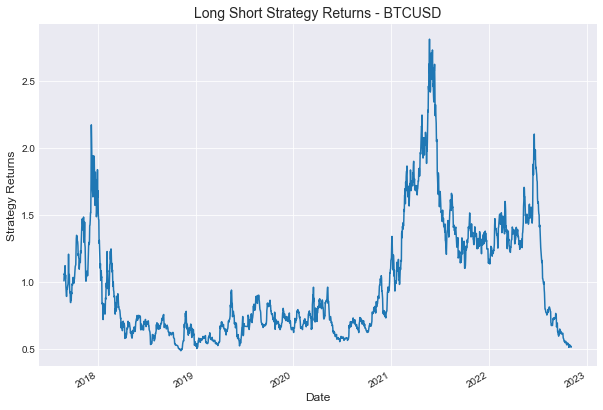

In [74]:
# Calculate and plot cumulative strategy returns
cum_strategy_returns = (stock_data['strategy_returns_minus_cost']+1).cumprod()
cum_strategy_returns.plot(figsize=(10, 7))

plt.title('Long Short Strategy Returns - BTCUSD', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Strategy Returns', fontsize=12)
plt.show()

As you can see, the strategy doesn't perform very well. Let's see how we can improve this strategy.

---




<a id='improve'></a> 
## Improve the strategy

In the above strategy, you generate both buy and sell signal when the criterion satisfies. 

Here you will generate only buy signal when the buy condition satisfies and exit the position when the sell condition meets. 

In [76]:
# Column to store new trading signals
stock_data['new_signal'] = np.nan


# Buy signal
stock_data.loc[(stock_data['SAR'] < stock_data['Last']) & (stock_data['fastk'] > stock_data['slowd']), 'new_signal'] = 1

# Exit signal
stock_data.loc[(stock_data['SAR'] > stock_data['Last']) & (stock_data['fastk'] < stock_data['slowd']), 'new_signal'] = 0

# Fill the missing values with last valid observation
stock_data = stock_data.fillna(method = 'ffill')

In [77]:
# Calculate strategy returns
stock_data['new_strategy_returns'] = (
    stock_data['stock_returns'] * stock_data['new_signal'].shift(1))

# Calculate net strategy returns
stock_data['new_strategy_returns_minus_cost'] = stock_data['new_strategy_returns'] - trading_cost

# Drop NaN values
stock_data = stock_data.dropna()

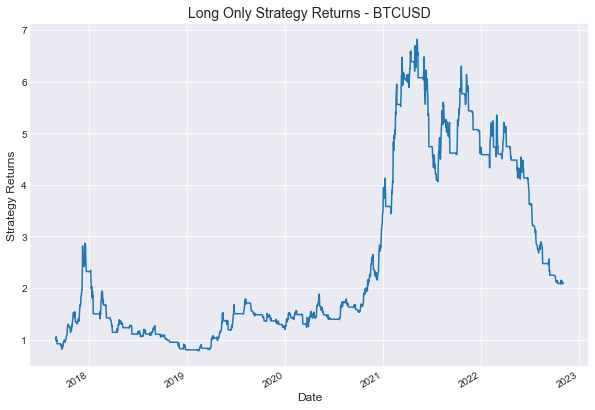

In [78]:
# Calculate and plot cumulative strategy returns
cum_strategy_returns = (stock_data['new_strategy_returns_minus_cost']+1).cumprod()
cum_strategy_returns.plot(figsize=(10, 7))

plt.title('Long Only Strategy Returns - BTCUSD', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Strategy Returns', fontsize=12)
plt.show()

As you can see, the long only strategy performs better than the long short strategy.

In the upcoming units, you will practice these codes through interactive exercises.<br><br>